In [1]:
import pandas as pd 
import pickle 
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans, AgglomerativeClustering 
from scipy.cluster import hierarchy
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer, silhouette_visualizer
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [2]:
# install threadpoolctl if kmeans fails during fitting 
# !pip install -U threadpoolctl 

In [3]:
# Load data preprocessor
with open("catalogue_merge_with_co2.pkl", 'rb') as file:
    catalogue = pickle.load(file)

catalogue.drop(columns=['_c0', ], inplace=True)
# Set marque values into capitalize 
catalogue.marque = catalogue.marque.str.capitalize()

In [4]:
print("shape : ", catalogue.shape)
display(catalogue.head())


shape :  (54, 11)


,marque,nom,puissance,longueur,nbPlaces,nbPortes,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie
0,Audi,A2 1.4,75,courte,5,5,False,18310,2851.800000,26.100000,191.600000
1,Audi,A2 1.4,75,courte,5,5,True,12817,2851.800000,26.100000,191.600000
2,Audi,A3 2.0 FSI,150,moyenne,5,5,False,28500,2851.800000,26.100000,191.600000
3,Audi,A3 2.0 FSI,150,moyenne,5,5,True,19950,2851.800000,26.100000,191.600000
4,Bmw,120i,150,moyenne,5,5,False,35800,7200.052632,39.263158,80.526316


# Clustering 

In [5]:
cols = catalogue.columns[catalogue.columns != "nom"]
X_catalogue = catalogue[cols].copy() 

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="error", drop = "if_binary"), ["marque", "longueur", "nbPlaces", "nbPortes", "occasion", ]), 
#     ('ohe_binary', OneHotEncoder(drop = "if_binary", handle_unknown="error"), ["nbPlaces", "nbPortes"]),
    ('scaling', StandardScaler(), ["puissance", "prix", 'bonus_malus', 'rejetsco2gkm', 'coutenergie'])
])

# pipe_ohe_scaling_catalogue = Pipeline(steps=[
#     ('ohe_and_scaling', column_transformer) 
# ])

X_catalogue = column_transformer.fit_transform(X_catalogue) 
X_catalogue.shape

(54, 33)

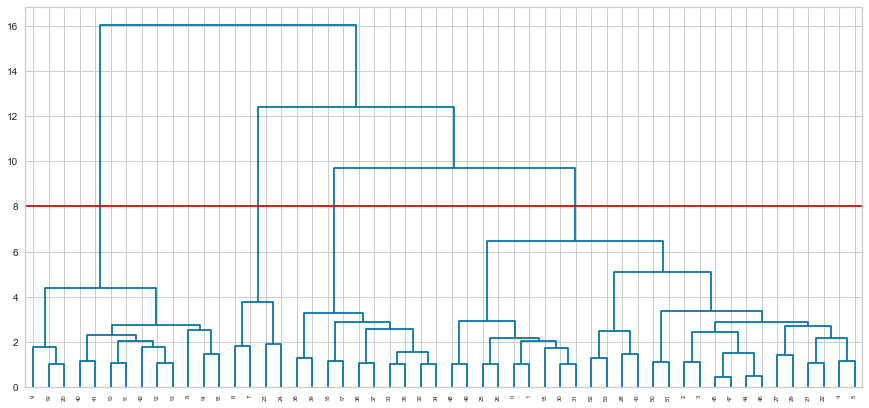

In [6]:
#plot dendogram
plt.figure(figsize=(15, 7))
hierarchy.dendrogram(hierarchy.linkage(pdist(X_catalogue.todense()) , method='ward'), color_threshold=0.1)
plt.axhline(8, c="r") 
plt.show()

<font color=blue size=4> En admettant la coupure à l'ordonée égale à 8, nous pouvons supposer que les véhicules sont regroupés selon 4 clusters </font>

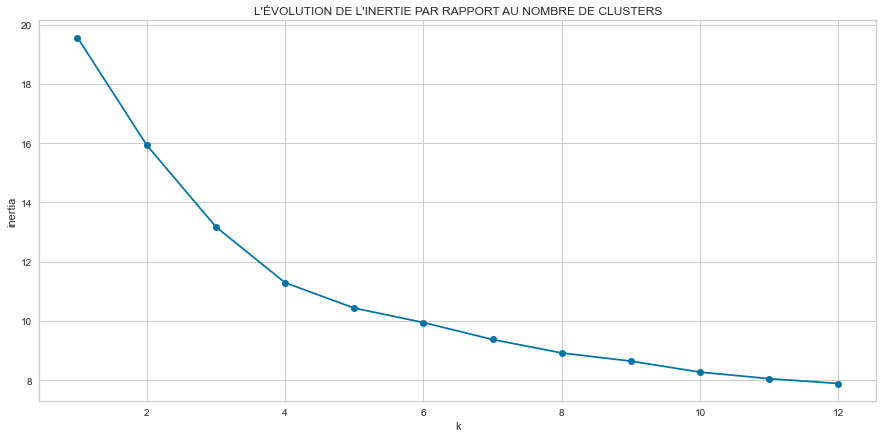

In [7]:
nb_clusters = 13
inertia = []
kmeans_instances = []
for k in range(1, nb_clusters):
    kmeans_instances.append(KMeans(n_clusters=k, random_state=RANDOM_STATE, algorithm="auto"))
    kmeans_instances[k-1].fit(X_catalogue)
    inertia.append(np.sqrt(kmeans_instances[k-1].inertia_))

plt.figure(figsize=(15, 7))
plt.title("L'évolution de l'inertie par rapport au nombre de clusters".upper())
plt.plot(range(1, nb_clusters), inertia, marker='o');
plt.grid(True)
plt.xlabel('k')
plt.ylabel('inertia');

<font color=blue size=5> Encore ici, le point d'inflexion en k=4 vient appuyer l'idée de 4 clusters </font>

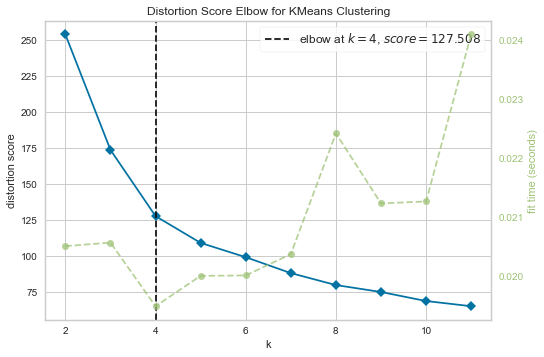

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_catalogue.toarray())       
visualizer.show()

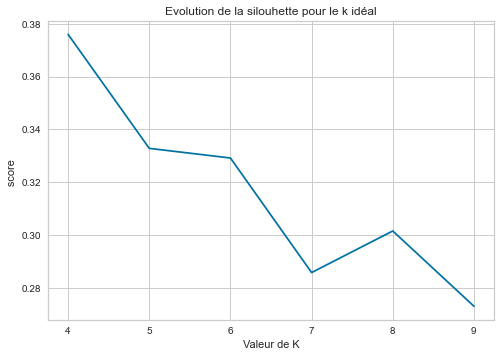

In [34]:
range_n_clusters = range(4,10)
silhouette_avg = [] 
for num_clusters in range_n_clusters: 
    cluster_labels = kmeans_instances[num_clusters-1].labels_
     # silhouette score
    silhouette_avg.append(silhouette_score(X_catalogue, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Valeur de K') 
plt.ylabel('score ') 
plt.title('Evolution de la silouhette pour le k idéal') 
plt.grid(True)
plt.show()

<font color=blue size=4> Finalement en se basant sur ces graphiques ci-dessus, nous décidons de choisir 4 clusters pour le clustering avec la méthode KMeans </font>

## Labelisation des véhicules du catalogue

In [35]:
catalogue['label'] = kmeans_instances[3].predict(X_catalogue)

In [36]:
catalogue.label.value_counts()

0    25
2    13
3    10
1     6
Name: label, dtype: int64

In [37]:
catalogue[catalogue.label == 0]

,marque,nom,puissance,longueur,nbPlaces,nbPortes,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie,label
0,Audi,A2 1.4,75,courte,5,5,False,18310,2851.800000,26.100000,191.600000,0
1,Audi,A2 1.4,75,courte,5,5,True,12817,2851.800000,26.100000,191.600000,0
2,Audi,A3 2.0 FSI,150,moyenne,5,5,False,28500,2851.800000,26.100000,191.600000,0
3,Audi,A3 2.0 FSI,150,moyenne,5,5,True,19950,2851.800000,26.100000,191.600000,0
4,Bmw,120i,150,moyenne,5,5,False,35800,7200.052632,39.263158,80.526316,0
5,Bmw,120i,150,moyenne,5,5,True,25060,7200.052632,39.263158,80.526316,0
18,Kia,Picanto 1.1,65,courte,5,5,False,8990,1376.500000,15.500000,132.750000,0
21,Mercedes,A200,136,moyenne,5,5,False,25900,8265.325424,187.627119,749.979661,0
22,Mercedes,A200,136,moyenne,5,5,True,18130,8265.325424,187.627119,749.979661,0
25,Mini,Copper 1.6 16V,115,courte,5,5,False,18200,1376.500000,21.500000,126.000000,0


In [38]:
catalogue[catalogue.label == 1]

,marque,nom,puissance,longueur,nbPlaces,nbPortes,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie,label
6,Bmw,M5,507,très longue,5,5,False,94800,7200.052632,39.263158,80.526316,1
7,Bmw,M5,507,très longue,5,5,True,66360,7200.052632,39.263158,80.526316,1
23,Mercedes,S500,306,très longue,5,5,False,101300,8265.325424,187.627119,749.979661,1
24,Mercedes,S500,306,très longue,5,5,True,70910,8265.325424,187.627119,749.979661,1
52,Volvo,S80 T6,272,très longue,5,5,False,50500,8753.000000,42.454545,72.727273,1
53,Volvo,S80 T6,272,très longue,5,5,True,35350,8753.000000,42.454545,72.727273,1


In [39]:
catalogue[catalogue.label == 2]

,marque,nom,puissance,longueur,nbPlaces,nbPortes,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie,label
8,Dacia,Logan 1.6 MPI,90,moyenne,5,5,False,7500,6794.36092,6794.36092,6794.36092,2
9,Daihatsu,Cuore 1.0,58,courte,5,3,False,8850,6794.36092,6794.36092,6794.36092,2
10,Fiat,Croma 2.2,147,longue,5,5,False,24780,6794.36092,6794.36092,6794.36092,2
11,Fiat,Croma 2.2,147,longue,5,5,True,17346,6794.36092,6794.36092,6794.36092,2
12,Ford,Mondeo 1.8,125,longue,5,5,False,23900,6794.36092,6794.36092,6794.36092,2
13,Ford,Mondeo 1.8,125,longue,5,5,True,16730,6794.36092,6794.36092,6794.36092,2
14,Honda,FR-V 1.7,125,longue,7,5,False,19550,6794.36092,6794.36092,6794.36092,2
15,Hyundaï,Matrix 1.6,103,longue,7,5,False,15960,6794.36092,6794.36092,6794.36092,2
19,Lancia,Ypsilon 1.4 16V,90,courte,5,3,False,13500,6794.36092,6794.36092,6794.36092,2
20,Lancia,Ypsilon 1.4 16V,90,courte,5,3,True,9450,6794.36092,6794.36092,6794.36092,2


In [40]:
catalogue[catalogue.label == 3]

,marque,nom,puissance,longueur,nbPlaces,nbPortes,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie,label
16,Jaguar,X-Type 2.5 V6,197,longue,5,5,False,37100,-6000.0,0.0,271.0,3
17,Jaguar,X-Type 2.5 V6,197,longue,5,5,True,25970,-6000.0,0.0,271.0,3
32,Renault,Espace 2.0T,165,longue,7,5,False,30350,-6000.0,0.0,206.0,3
33,Renault,Espace 2.0T,165,longue,7,5,True,21245,-6000.0,0.0,206.0,3
34,Renault,Laguna 2.0T,170,longue,5,5,False,27300,-6000.0,0.0,206.0,3
35,Renault,Laguna 2.0T,170,longue,5,5,True,19110,-6000.0,0.0,206.0,3
36,Renault,Megane 2.0 16V,135,moyenne,5,5,False,22350,-6000.0,0.0,206.0,3
37,Renault,Megane 2.0 16V,135,moyenne,5,5,True,15644,-6000.0,0.0,206.0,3
38,Renault,Vel Satis 3.5 V6,245,très longue,5,5,False,49200,-6000.0,0.0,206.0,3
39,Renault,Vel Satis 3.5 V6,245,très longue,5,5,True,34440,-6000.0,0.0,206.0,3


In [41]:
#Save vechicles by categorie with pickle in order to show its in web interface
categories = []
for label in range(4):
    categories.append(catalogue[catalogue.label == label] )

with open("vehicle_categories_co2_based.pkl", 'wb') as file:
    pickle.dump(categories, file)

In [42]:
categories[1]

,marque,nom,puissance,longueur,nbPlaces,nbPortes,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie,label
6,Bmw,M5,507,très longue,5,5,False,94800,7200.052632,39.263158,80.526316,1
7,Bmw,M5,507,très longue,5,5,True,66360,7200.052632,39.263158,80.526316,1
23,Mercedes,S500,306,très longue,5,5,False,101300,8265.325424,187.627119,749.979661,1
24,Mercedes,S500,306,très longue,5,5,True,70910,8265.325424,187.627119,749.979661,1
52,Volvo,S80 T6,272,très longue,5,5,False,50500,8753.000000,42.454545,72.727273,1
53,Volvo,S80 T6,272,très longue,5,5,True,35350,8753.000000,42.454545,72.727273,1


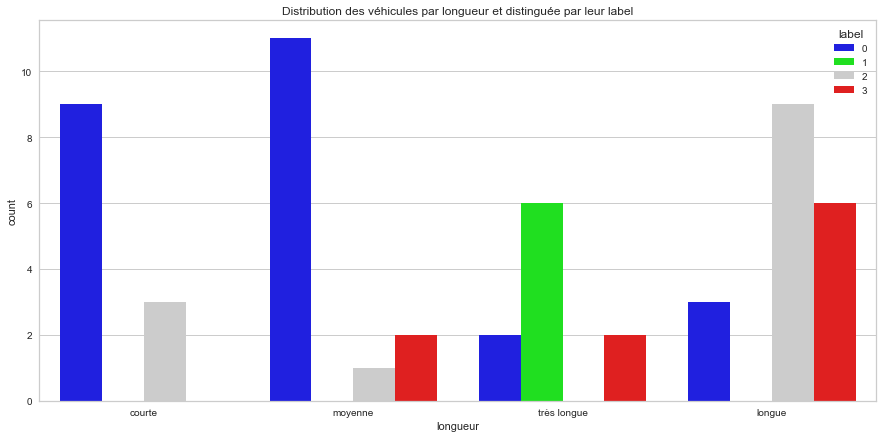

In [43]:
plt.figure(figsize=(15, 7))
plt.title('Distribution des véhicules par longueur et distinguée par leur label')
sns.countplot(data=catalogue, x="longueur", hue="label", palette=["#00f", "#0f0", "#ccc", "#f00", "#ff9"])
plt.show()

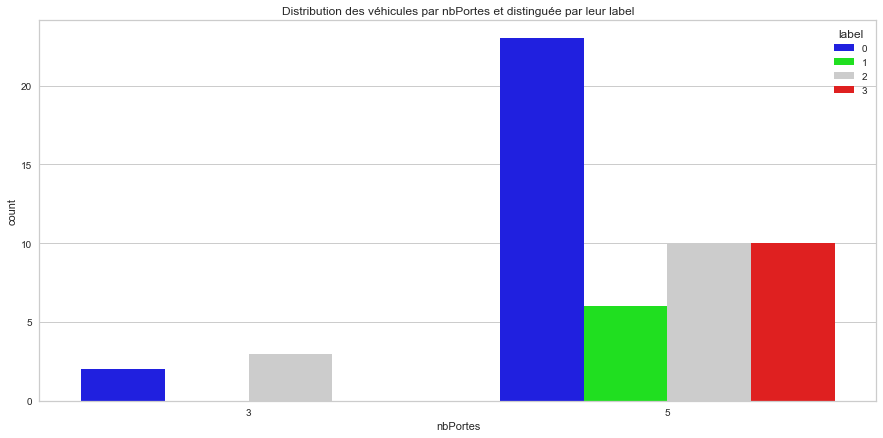

In [44]:
plt.figure(figsize=(15, 7))
plt.title('Distribution des véhicules par nbPortes et distinguée par leur label')
sns.countplot(data=catalogue, x="nbPortes", hue="label", palette=["#00f", "#0f0", "#ccc", "#f00", "#ff9"])
plt.show()

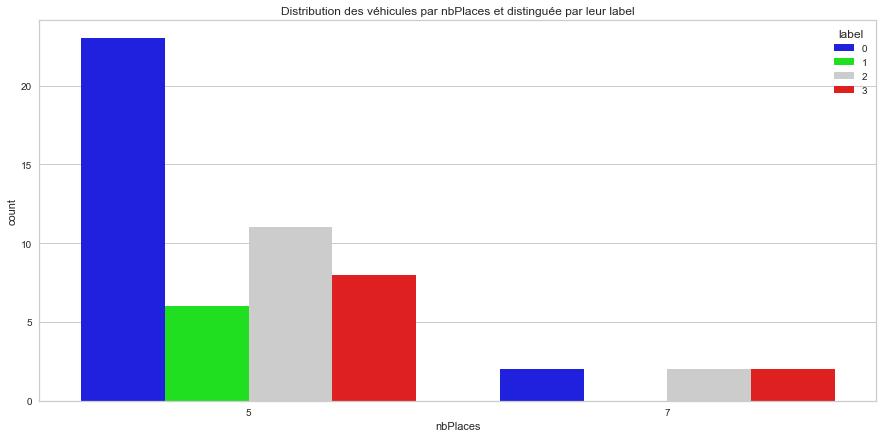

In [45]:
plt.figure(figsize=(15, 7))
plt.title('Distribution des véhicules par nbPlaces et distinguée par leur label')
sns.countplot(data=catalogue, x="nbPlaces", hue="label", palette=["#00f", "#0f0", "#ccc", "#f00", "#ff9"])
plt.show()

# Merging 

In [46]:
path_to_CO2 = "./Données communes/CO2.csv"
CO2 = pd.read_csv(path_to_CO2)

with open('immatriculations_with_co2.pkl', 'rb') as file :
    immatriculations = pickle.load(file) 
    
# immatriculations.occasion = np.where(immatriculations.occasion, 1,0)

path_to_clients = "./Données par groupe/Groupe_TPT_6/Clients_61.csv"
clients = pd.read_csv(path_to_clients, encoding="ISO-8859-1")

In [47]:
immatriculations.head(3)

,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie
0,3176 TS 67,Renault,Laguna 2.0T,170,longue,5,5,blanc,0,27300,-6000.000000,0.000000,206.000000
1,3721 QS 49,Volvo,S80 T6,272,trÃ¨s longue,5,5,noir,0,50500,8753.000000,42.454545,72.727273
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,moyenne,5,5,gris,1,16029,4537.857143,23.428571,96.000000


In [48]:
# Correction de la valeur 'très longue' dans la colonne longueur
immatriculations.loc[immatriculations.longueur == 'trÃ¨s longue', 'longueur'] = "très longue"
immatriculations.marque = immatriculations.marque.str.capitalize()

In [49]:
# Suppresion des doublons 
immatriculations = immatriculations.drop_duplicates()
immatriculations.drop(index=immatriculations[immatriculations.immatriculation.duplicated()].index, inplace=True)

In [54]:
X_immatriculations = column_transformer.transform(immatriculations)
immatriculations['label'] = kmeans_instances[3].predict(X_immatriculations)

<AxesSubplot:xlabel='label', ylabel='count'>

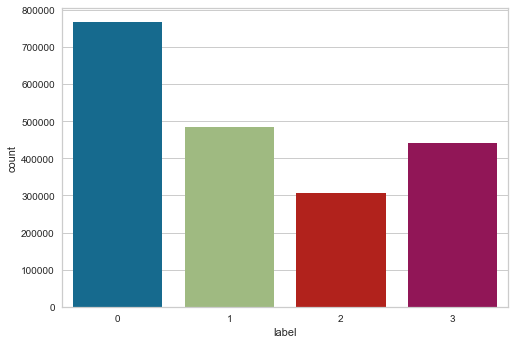

In [55]:
sns.countplot(x=immatriculations.label)

# Join immatriculations to Clients 

In [57]:
clients.drop(index=clients[clients.immatriculation.duplicated()].index, inplace=True)

In [58]:
clients_immatriculations = clients.merge(immatriculations, on="immatriculation")

In [59]:
clients_immatriculations.head(3)

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,bonus_malus,rejetsco2gkm,coutenergie,label
0,62,M,1262,En Couple,1,false,6290 DM 24,Saab,9.3 1.8T,150,longue,5,5,noir,0,38600,6794.36092,6794.36092,6794.36092,2
1,68,M,514,En Couple,2,false,7530 VH 52,Saab,9.3 1.8T,150,longue,5,5,rouge,1,27020,6794.36092,6794.36092,6794.36092,2
2,26,F,181,En Couple,4,true,7168 HX 32,Renault,Vel Satis 3.5 V6,245,très longue,5,5,bleu,1,34440,-6000.00000,0.00000,206.00000,3


# Classification

In [60]:
#Suppression des colonnes venant de immatriculations (sauf la variable cible )
clients_labeled = clients_immatriculations.drop(columns=["immatriculation", "marque",	"nom", "puissance",	"longueur",	"nbPlaces",	"nbPortes",	"couleur",	"occasion", "prix"])
clients_labeled.rename(columns={"2eme voiture" : "VoitureN2"}, inplace=True)

In [63]:
clients_labeled.head(3)

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,VoitureN2,bonus_malus,rejetsco2gkm,coutenergie,label
0,62,M,1262,En Couple,1,false,6794.36092,6794.36092,6794.36092,2
1,68,M,514,En Couple,2,false,6794.36092,6794.36092,6794.36092,2
2,26,F,181,En Couple,4,true,-6000.00000,0.00000,206.00000,3


In [64]:
map_sexe = {"M": "Masculin", "F": "Féminin", "Masculin" : "Masculin", "Homme" : "Masculin", "Féminin" : "Féminin", "Femme" : "Féminin"}
map_situationFamiliale = {"En Couple": "En Couple", "Célibataire": "Célibataire", "Seule" : "Célibataire", "Marié(e)" : "En Couple", "Seul" : "Célibataire"}
map_VoitureN2 = {"true": "Oui", "false": "Non"}

clients_labeled.age = pd.to_numeric(clients_labeled.age, errors="coerce")
clients_labeled.taux = pd.to_numeric(clients_labeled.taux, errors="coerce")
clients_labeled.nbEnfantsAcharge = pd.to_numeric(clients_labeled.nbEnfantsAcharge, errors="coerce") 

clients_labeled['VoitureN2'] = clients_labeled['VoitureN2'].map(map_VoitureN2)
clients_labeled.sexe = clients_labeled.sexe.map(map_sexe)
clients_labeled.situationFamiliale = clients_labeled.situationFamiliale.map(map_situationFamiliale)

<font color="blue"> Plusieurs colonnes ont des valeurs manquantes mais en très faible proportion. 

Comme avec la première approche (sans l'ajout des données de CO2.csv), nous faisons le choix de les supprimer.

 </font>

In [65]:
clients_labeled_cleaned = clients_labeled.copy()

In [66]:
clients_labeled_cleaned.dropna(inplace=True)
clients_labeled_cleaned.drop(index = clients_labeled_cleaned[clients_labeled_cleaned.age.isin([-1]) | clients_labeled_cleaned.taux.isin([-1]) | clients_labeled_cleaned.nbEnfantsAcharge.isin([-1])].index, inplace=True)

In [67]:
clients_labeled_cleaned.describe(include="all")

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,VoitureN2,bonus_malus,rejetsco2gkm,coutenergie,label
count,98171.000000,98171,98171.000000,98171,98171.000000,98171,98171.000000,98171.000000,98171.000000,98171.000000
unique,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN
top,NaN,Masculin,NaN,En Couple,NaN,Non,NaN,NaN,NaN,NaN
freq,NaN,68705,NaN,63801,NaN,85354,NaN,NaN,NaN,NaN
mean,43.770584,NaN,607.820874,NaN,1.247191,NaN,3116.871094,1074.826664,1233.629519,1.209451
std,18.271554,NaN,333.909303,NaN,1.383272,NaN,5262.557697,2431.603294,2370.922642,1.172949
min,18.000000,NaN,150.000000,NaN,0.000000,NaN,-6000.000000,0.000000,72.727273,0.000000
25%,28.000000,NaN,422.000000,NaN,0.000000,NaN,1376.500000,15.833333,96.000000,0.000000
50%,42.000000,NaN,522.000000,NaN,1.000000,NaN,4537.857143,26.100000,191.600000,1.000000
75%,56.000000,NaN,822.000000,NaN,2.000000,NaN,7200.052632,160.000000,681.200000,2.000000


In [68]:
clients_labeled_cleaned['tranche_age'] = clients_labeled_cleaned.age.map(lambda x : 0 if x < 35 else (1 if x>=35 and x<60 else 2))

In [69]:
clients_labeled_cleaned.head()

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,VoitureN2,bonus_malus,rejetsco2gkm,coutenergie,label,tranche_age
0,62.0,Masculin,1262.0,En Couple,1.0,Non,6794.360920,6794.360920,6794.360920,2,2
1,68.0,Masculin,514.0,En Couple,2.0,Non,6794.360920,6794.360920,6794.360920,2,2
2,26.0,Féminin,181.0,En Couple,4.0,Oui,-6000.000000,0.000000,206.000000,3,0
3,34.0,Masculin,829.0,Célibataire,0.0,Non,2851.800000,26.100000,191.600000,0,0
4,50.0,Masculin,1169.0,En Couple,4.0,Non,7200.052632,39.263158,80.526316,1,1


In [70]:
clients_labeled_cleaned.to_pickle('clients_labeled_cleaned_05_04_2023.pkl')